# 步驟 1：設置環境與依賴

In [ ]:
# 安裝必要的庫（如果 Kaggle 預設環境未包含）
!pip install -q torch torchvision opencv-python scikit-image

# 導入依賴
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import matplotlib.pyplot as plt
from IPython.display import display, Image

# 步驟 2：定義模型類別

In [ ]:
# 生成器模型
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.det_conv0 = nn.Sequential(
            nn.Conv2d(4, 32, 3, 1, 1), nn.ReLU()
        )
        self.det_conv1 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU()
        )
        self.det_conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU()
        )
        self.det_conv3 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU()
        )
        self.det_conv4 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU()
        )
        self.det_conv5 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1), nn.ReLU()
        )
        self.conv_i = nn.Sequential(nn.Conv2d(64, 32, 3, 1, 1), nn.Sigmoid())
        self.conv_f = nn.Sequential(nn.Conv2d(64, 32, 3, 1, 1), nn.Sigmoid())
        self.conv_g = nn.Sequential(nn.Conv2d(64, 32, 3, 1, 1), nn.Tanh())
        self.conv_o = nn.Sequential(nn.Conv2d(64, 32, 3, 1, 1), nn.Sigmoid())
        self.det_conv_mask = nn.Sequential(nn.Conv2d(32, 1, 3, 1, 1))
        self.conv1 = nn.Sequential(nn.Conv2d(4, 64, 5, 1, 2), nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU())
        self.conv3 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1), nn.ReLU())
        self.conv4 = nn.Sequential(nn.Conv2d(128, 256, 3, 2, 1), nn.ReLU())
        self.conv5 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU())
        self.conv6 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU())
        self.diconv1 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 2, dilation=2), nn.ReLU())
        self.diconv2 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 4, dilation=4), nn.ReLU())
        self.diconv3 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 8, dilation=8), nn.ReLU())
        self.diconv4 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 16, dilation=16), nn.ReLU())
        self.conv7 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU())
        self.conv8 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU())
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReflectionPad2d((1, 0, 1, 0)),
            nn.AvgPool2d(2, stride=1), nn.ReLU()
        )
        self.conv9 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1), nn.ReLU())
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReflectionPad2d((1, 0, 1, 0)),
            nn.AvgPool2d(2, stride=1), nn.ReLU()
        )
        self.conv10 = nn.Sequential(nn.Conv2d(64, 32, 3, 1, 1), nn.ReLU())
        self.outframe1 = nn.Sequential(nn.Conv2d(256, 3, 3, 1, 1), nn.ReLU())
        self.outframe2 = nn.Sequential(nn.Conv2d(128, 3, 3, 1, 1), nn.ReLU())
        self.output = nn.Sequential(nn.Conv2d(32, 3, 3, 1, 1))

    def forward(self, input):
        batch_size, row, col = input.size(0), input.size(2), input.size(3)
        mask = torch.ones(batch_size, 1, row, col).to(input.device) / 2.
        h = torch.zeros(batch_size, 32, row, col).to(input.device)
        c = torch.zeros(batch_size, 32, row, col).to(input.device)
        mask_list = []
        for _ in range(4):  # ITERATION = 4
            x = torch.cat((input, mask), 1)
            x = self.det_conv0(x)
            resx = x
            x = F.relu(self.det_conv1(x) + resx)
            resx = x
            x = F.relu(self.det_conv2(x) + resx)
            resx = x
            x = F.relu(self.det_conv3(x) + resx)
            resx = x
            x = F.relu(self.det_conv4(x) + resx)
            resx = x
            x = F.relu(self.det_conv5(x) + resx)
            x = torch.cat((x, h), 1)
            i = self.conv_i(x)
            f = self.conv_f(x)
            g = self.conv_g(x)
            o = self.conv_o(x)
            c = f * c + i * g
            h = o * F.tanh(c)
            mask = self.det_conv_mask(h)
            mask_list.append(mask)
        x = torch.cat((input, mask), 1)
        x = self.conv1(x)
        res1 = x
        x = self.conv2(x)
        x = self.conv3(x)
        res2 = x
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.diconv1(x)
        x = self.diconv2(x)
        x = self.diconv3(x)
        x = self.diconv4(x)
        x = self.conv7(x)
        x = self.conv8(x)
        frame1 = self.outframe1(x)
        x = self.deconv1(x)
        x = x + res2
        x = self.conv9(x)
        frame2 = self.outframe2(x)
        x = self.deconv2(x)
        x = x + res1
        x = self.conv10(x)
        x = self.output(x)
        return mask_list, frame1, frame2, x

# 判別器模型（未來可能使用，現階段可選）
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 8, 5, 1, 2), nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(8, 16, 5, 1, 2), nn.ReLU())
        self.conv3 = nn.Sequential(nn.Conv2d(16, 64, 5, 1, 2), nn.ReLU())
        self.conv4 = nn.Sequential(nn.Conv2d(64, 128, 5, 1, 2), nn.ReLU())
        self.conv5 = nn.Sequential(nn.Conv2d(128, 128, 5, 1, 2), nn.ReLU())
        self.conv6 = nn.Sequential(nn.Conv2d(128, 128, 5, 1, 2), nn.ReLU())
        self.conv_mask = nn.Sequential(nn.Conv2d(128, 1, 5, 1, 2))
        self.conv7 = nn.Sequential(nn.Conv2d(128, 64, 5, 4, 1), nn.ReLU())
        self.conv8 = nn.Sequential(nn.Conv2d(64, 32, 5, 4, 1), nn.ReLU())
        self.fc = nn.Sequential(
            nn.Linear(32 * 14 * 14, 1024), nn.Linear(1024, 1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        mask = self.conv_mask(x)
        x = self.conv7(x * mask)
        x = self.conv7(x)
        x = self.conv8(x)
        x = x.view(x.size(0), -1)
        return mask, self.fc(x)

# 步驟 3：定義工具函數與資料載入器

In [ ]:
# 工具函數
def align_to_four(img):
    a_row = int(img.shape[0] / 4) * 4
    a_col = int(img.shape[1] / 4) * 4
    return img[0:a_row, 0:a_col]

def calc_psnr(im1, im2):
    im1_y = cv2.cvtColor(im1, cv2.COLOR_BGR2YCR_CB)[:, :, 0]
    im2_y = cv2.cvtColor(im2, cv2.COLOR_BGR2YCR_CB)[:, :, 0]
    return compare_psnr(im1_y, im2_y)

def calc_ssim(im1, im2):
    im1_y = cv2.cvtColor(im1, cv2.COLOR_BGR2YCR_CB)[:, :, 0]
    im2_y = cv2.cvtColor(im2, cv2.COLOR_BGR2YCR_CB)[:, :, 0]
    return compare_ssim(im1_y, im2_y)

# 資料載入器
class RaindropDataset(Dataset):
    def __init__(self, input_dir, gt_dir=None):
        self.input_dir = input_dir
        self.gt_dir = gt_dir
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # 僅轉為張量，不進行額外歸一化
        ])
        self.image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.input_dir, img_name)
        img = cv2.imread(img_path)  # 保持 BGR 格式
        img = align_to_four(img)
        img = self.transform(img)  # 轉為張量，範圍 [0, 1]
        sample = {"image": img, "name": img_name}
        if self.gt_dir:
            gt_name = img_name.replace('_rain', '_clean')
            gt_path = os.path.join(self.gt_dir, gt_name)
            if not os.path.exists(gt_path):
                raise FileNotFoundError(f"找不到對應的真值圖像：{gt_path}")
            gt = cv2.imread(gt_path)  # 保持 BGR 格式
            gt = align_to_four(gt)
            gt = self.transform(gt)
            sample["gt"] = gt
        return sample

def get_dataloader(input_dir, gt_dir=None, batch_size=1):
    dataset = RaindropDataset(input_dir, gt_dir)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

# 步驟 4：定義推理流程

In [ ]:
class DeRainPipeline:
    def __init__(self, model_path, device='cuda'):
        self.model = Generator().to(device)
        self.model.load_state_dict(torch.load(model_path, map_location=device))
        self.model.eval()
        self.device = device

    def predict(self, image):
        image = align_to_four(image)
        image = np.array(image, dtype='float32') / 255.0  # 已經在 Dataset 中處理為 [0, 1]
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            _, _, _, out = self.model(image)
        
        print(f"Model raw output range: min={out.min()}, max={out.max()}")
        
        out = out.cpu().numpy().squeeze().transpose(1, 2, 0)
        out = out * 255  # 與原作者一致，假設範圍 [0, 1]
        out = np.clip(out, 0, 255)
        out = out.astype(np.uint8)
        return out  # 保持 BGR 格式

    def run_demo(self, input_dir, output_dir):
        os.makedirs(output_dir, exist_ok=True)
        dataloader = get_dataloader(input_dir)
        for sample in dataloader:
            img = sample["image"].to(self.device)
            img_name = sample["name"][0]
            with torch.no_grad():
                mask_list, frame1, frame2, out = self.model(img)
            
            mask = mask_list[-1].cpu().numpy().squeeze()
            mask = (mask * 0.5 + 0.5) * 255
            mask = np.clip(mask, 0, 255).astype(np.uint8)
            cv2.imwrite(os.path.join(output_dir, f"mask_{img_name}"), mask)
            
            frame1 = frame1.cpu().numpy().squeeze().transpose(1, 2, 0)
            frame1 = (frame1 * 0.5 + 0.5) * 255
            frame1 = np.clip(frame1, 0, 255).astype(np.uint8)
            cv2.imwrite(os.path.join(output_dir, f"frame1_{img_name}"), frame1)
            
            frame2 = frame2.cpu().numpy().squeeze().transpose(1, 2, 0)
            frame2 = (frame2 * 0.5 + 0.5) * 255
            frame2 = np.clip(frame2, 0, 255).astype(np.uint8)
            cv2.imwrite(os.path.join(output_dir, f"frame2_{img_name}"), frame2)
            
            out = out.cpu().numpy().squeeze().transpose(1, 2, 0)
            out = out * 255
            out = np.clip(out, 0, 255)
            result = out.astype(np.uint8)
            
            cv2.imwrite(os.path.join(output_dir, img_name), result)
            
            plt.figure(figsize=(15, 10))
            plt.subplot(2, 3, 1)
            plt.imshow(cv2.imread(os.path.join(input_dir, img_name)))
            plt.title("Input")
            plt.subplot(2, 3, 2)
            plt.imshow(mask, cmap='gray')
            plt.title("Raindrop Mask")
            plt.subplot(2, 3, 3)
            plt.imshow(frame1)
            plt.title("Frame1")
            plt.subplot(2, 3, 4)
            plt.imshow(frame2)
            plt.title("Frame2")
            plt.subplot(2, 3, 5)
            plt.imshow(result)
            plt.title("Output")
            plt.show()

    def run_test(self, input_dir, gt_dir, output_dir):
        os.makedirs(output_dir, exist_ok=True)
        dataloader = get_dataloader(input_dir, gt_dir)
        cumulative_psnr = 0
        cumulative_ssim = 0
        num = 0
        for sample in dataloader:
            img = sample["image"].to(self.device)
            gt = sample["gt"].to(self.device)
            img_name = sample["name"][0]
            with torch.no_grad():
                _, _, _, out = self.model(img)
            out = out.cpu().numpy().squeeze().transpose(1, 2, 0)
            out = out * 255
            out = np.clip(out, 0, 255)
            result = out.astype(np.uint8)
            
            gt_img = gt.cpu().numpy().squeeze().transpose(1, 2, 0)
            gt_img = gt_img * 255
            gt_img = np.clip(gt_img, 0, 255)
            gt_img = gt_img.astype(np.uint8)
            
            cur_psnr = calc_psnr(result, gt_img)
            cur_ssim = calc_ssim(result, gt_img)
            cumulative_psnr += cur_psnr
            cumulative_ssim += cur_ssim
            num += 1
            
            cv2.imwrite(os.path.join(output_dir, img_name), result)
            print(f"Image: {img_name}, PSNR: {cur_psnr:.4f}, SSIM: {cur_ssim:.4f}")
        
        avg_psnr = cumulative_psnr / num
        avg_ssim = cumulative_ssim / num
        print(f"Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}")
        
    def run_single_image(self, image_path, output_dir):
        os.makedirs(output_dir, exist_ok=True)
        
        # 讀取圖像
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"無法載入圖像：{image_path}")
        
        # 保存原始圖像名稱
        img_name = os.path.basename(image_path)
        
        # 調整圖像尺寸並進行推理
        img_processed = align_to_four(img)
        result = self.predict(img_processed)
        
        # 保存去雨結果
        output_path = os.path.join(output_dir, f"derained_{img_name}")
        cv2.imwrite(output_path, result)
        
        # 可視化去雨前後的圖像
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Before DeRain")
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title("After DeRain")
        plt.axis('off')
        plt.show()
        
        print(f"去雨結果已保存至：{output_path}")

# 步驟 5：主執行邏輯

Running Demo Mode...


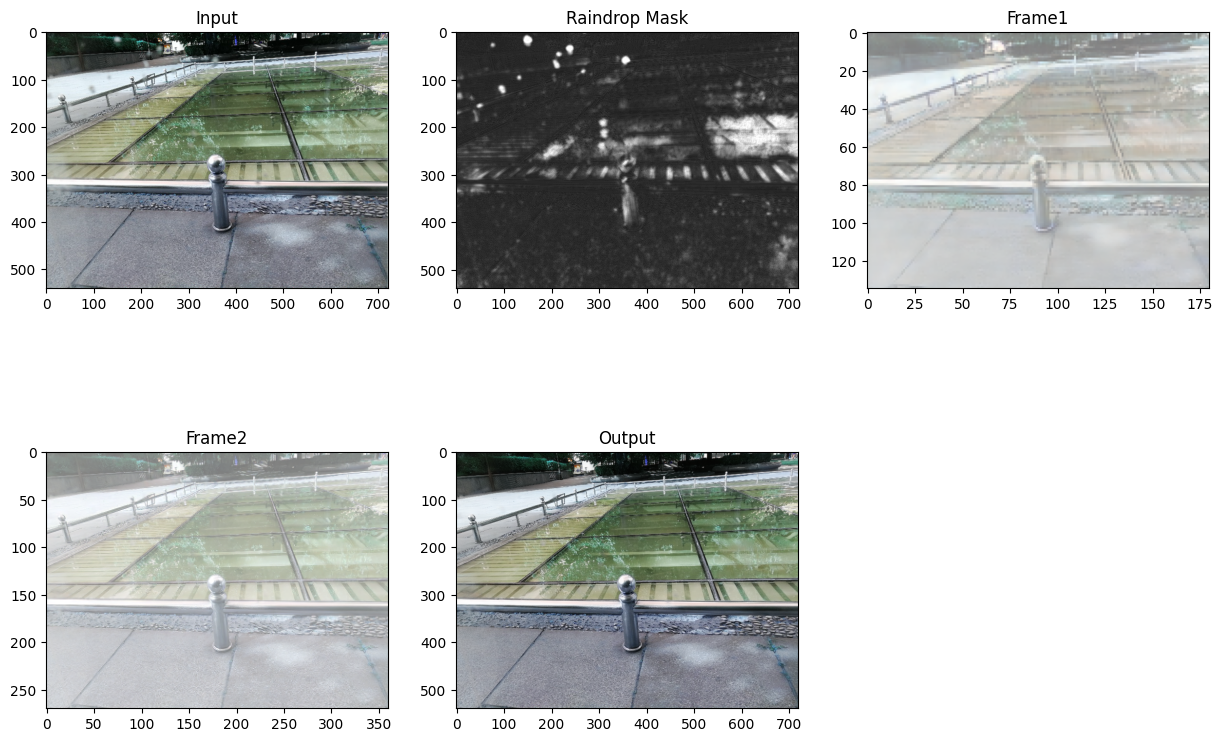

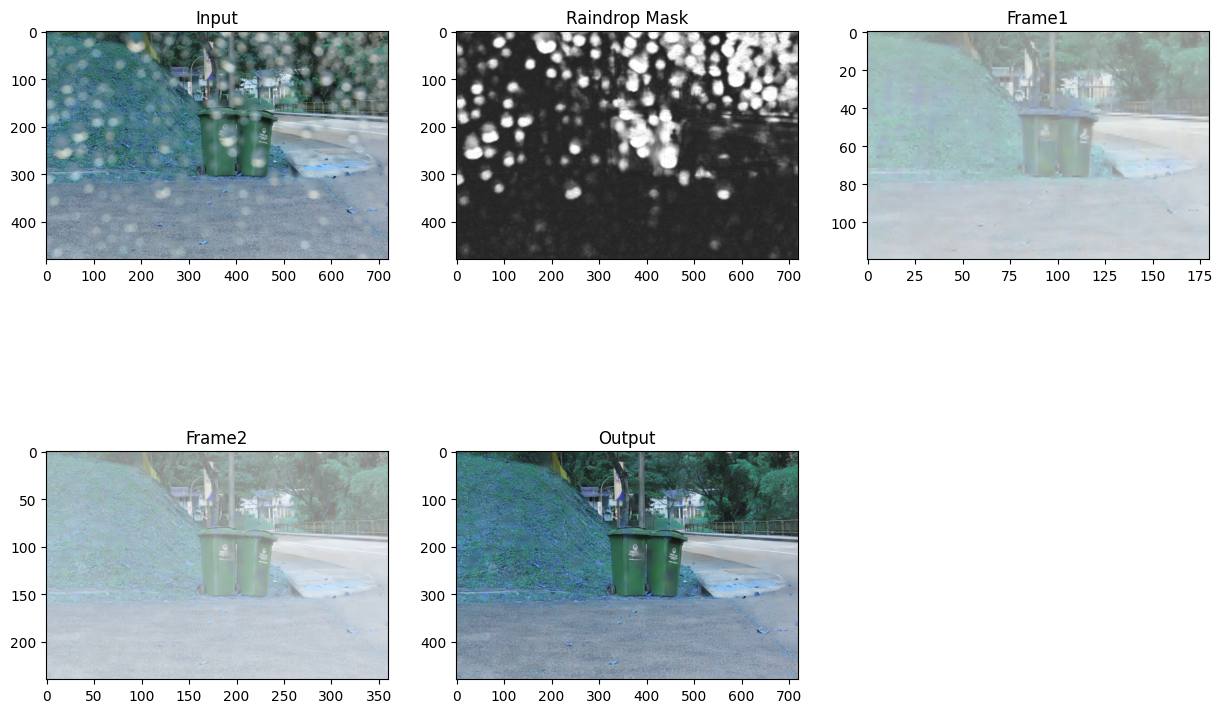

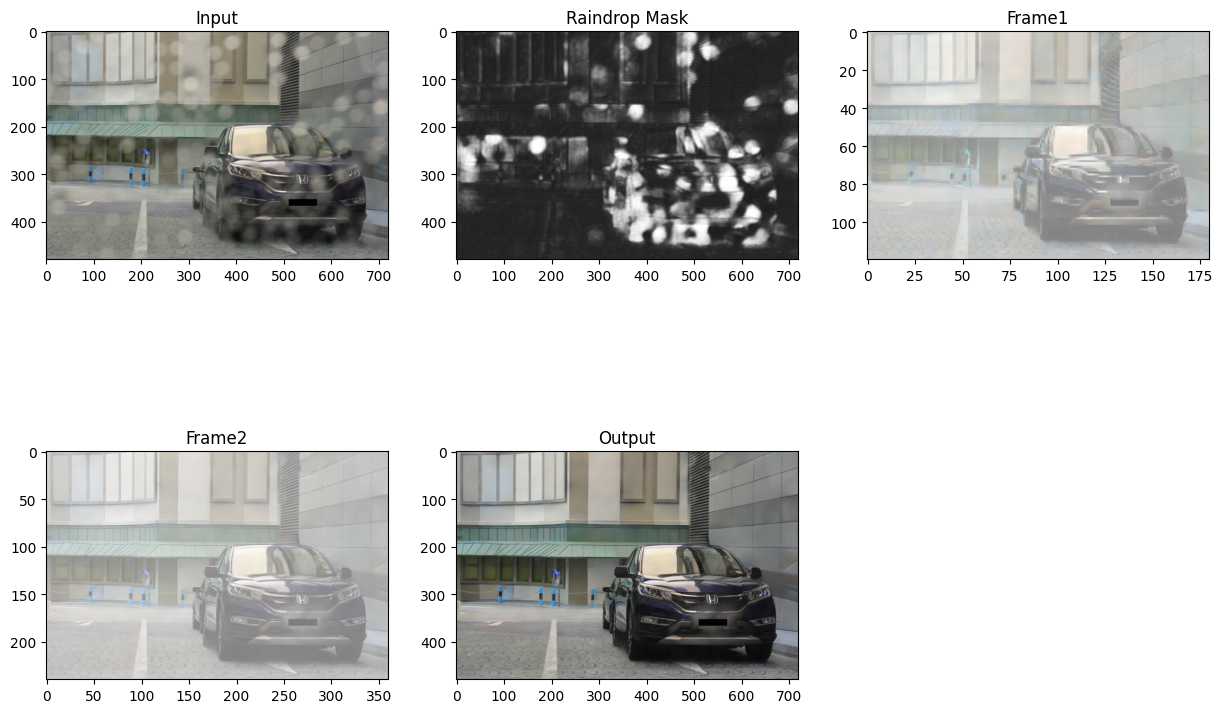

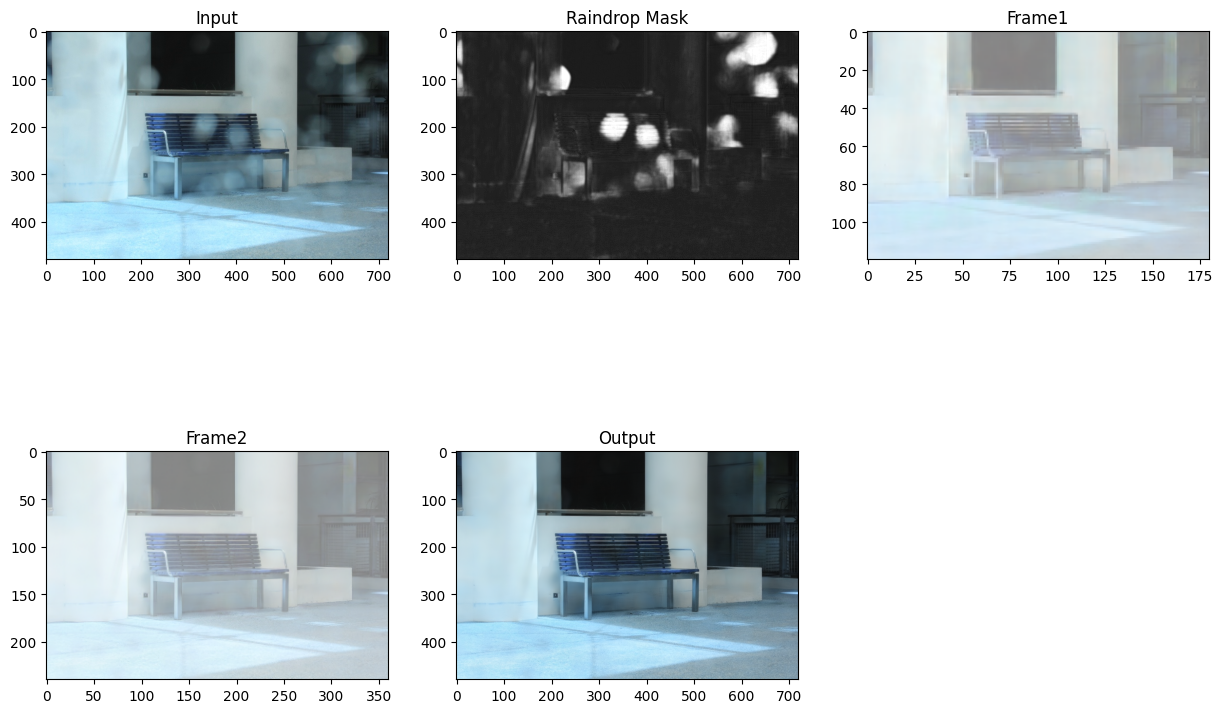

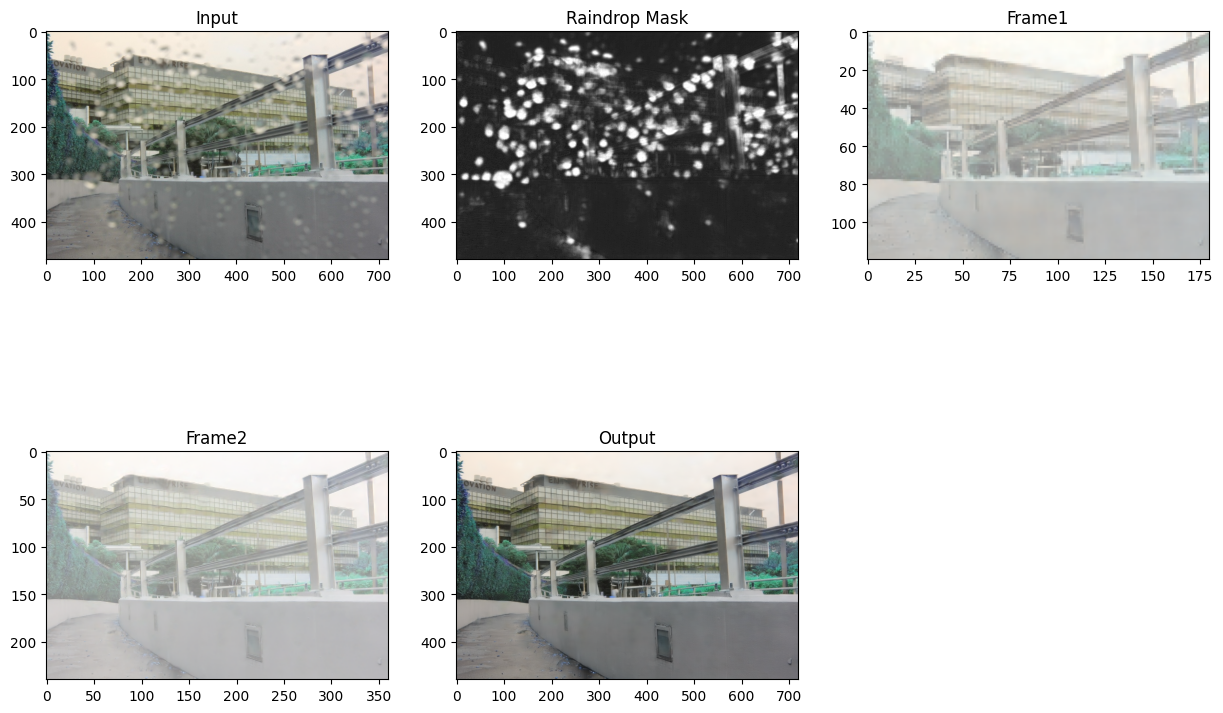

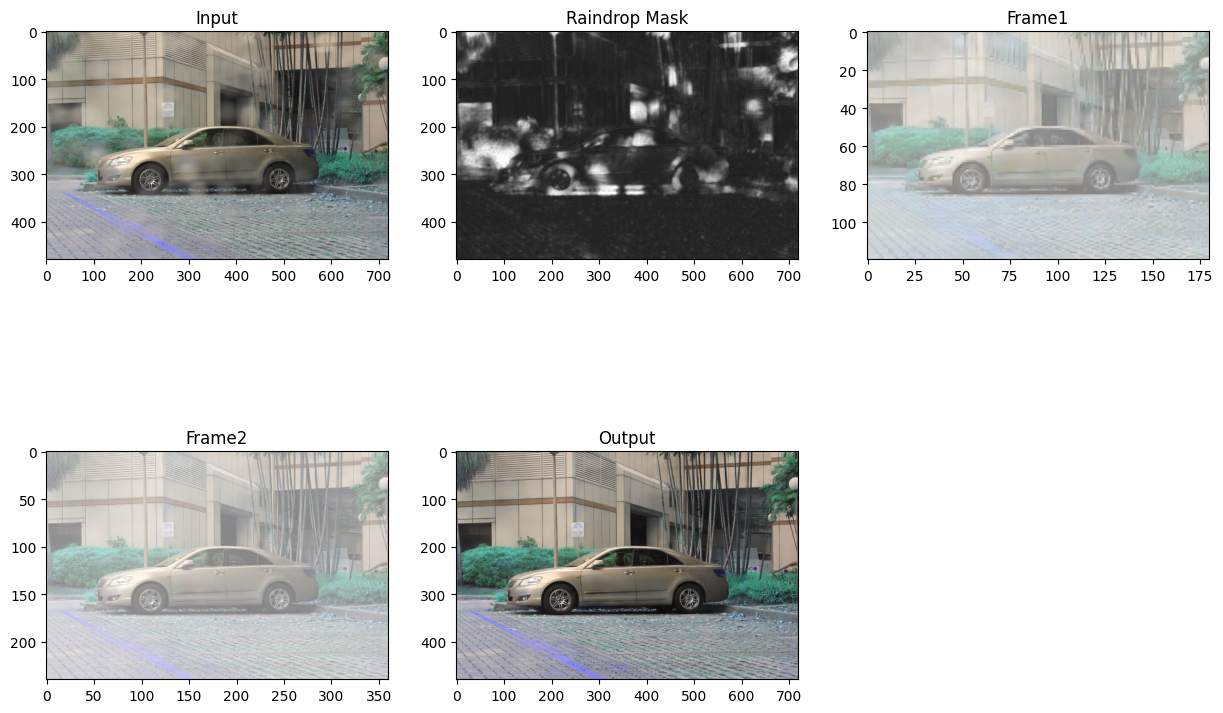

In [ ]:
'''
# 設置路徑（根據 Kaggle 實際路徑）
model_path = '/kaggle/input/derain_model/pytorch/default/1/gen.pkl'
input_dir = '/kaggle/input/deraindataset/test_b/data'  # 輸入圖像目錄
gt_dir = '/kaggle/input/deraindataset/test_b/gt'      # 真值圖像目錄
output_dir = '/kaggle/working/output'                 # 輸出目錄

# 初始化 Pipeline
pipeline = DeRainPipeline(model_path, device='cuda')

# 運行 Demo 模式
print("Running Demo Mode...")
pipeline.run_demo(input_dir, output_dir)

# 運行 Test 模式（取消註釋以執行）
print("Running Test Mode...")
pipeline.run_test(input_dir, gt_dir, output_dir)
'''

# 測試自己的照片

In [ ]:
# 設置路徑
model_path = '/kaggle/input/derain_model/pytorch/default/1/gen.pkl'
image_path = '/kaggle/input/deraindataset/test_b/data/105_rain.jpg'
output_dir = '/kaggle/working/output'

# 初始化 Pipeline
pipeline = DeRainPipeline(model_path, device='cuda')

# 測試單張圖像
print("Running Single Image DeRain...")
pipeline.run_single_image(image_path, output_dir)

# 如果仍需要運行其他模式，可以取消以下註釋
# print("Running Demo Mode...")
# pipeline.run_demo(input_dir, output_dir)
# print("Running Test Mode...")
# pipeline.run_test(input_dir, gt_dir, output_dir)